## WikiArt General Exploratory Data Analysis

In [68]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import time 
import pandas as pd
import customize_dataloader as cd
import os
import seaborn as sns
from collections import defaultdict


torch.manual_seed(0) # set the random seed


## Load dataset with the customized dataloader function.

In [9]:
# Example usage:
directory_path = "./wikiart_subset"
folders = cd.get_folder_structure(directory_path)
print("Folder names:", folders)


Folder names: {'abstract_expressionism': ['aaron-siskind', 'ad-reinhardt', 'adja-yunkers', 'al-held', 'albert-irvin', 'alexander-bogen', 'alice-rahon', 'anne-ryan', 'armand-vaillancourt', 'arthur-pinajian', 'barnett-newman', 'basil-beattie', 'behjat-sadr', 'bernard-cohen', 'betty-parsons', 'blinky-palermo', 'brice-marden', 'bui-xuan-phai', 'charles-gibbons', 'conrad-marca-relli', 'cy-twombly', 'daan-lemaire', 'dan-christensen', 'david-smith', 'edward-corbett', 'elaine-de-kooning', 'elmer-bischoff', 'endre-rozsda', 'esteban-vicente', 'etel-adnan', 'fernand-leduc', 'fernando-garcia-ponce', 'forrest-bess', 'frank-bowling', 'franz-kline', 'friedel-dzubas', 'gary-wragg', 'gillian-ayres', 'giorgio-cavallon', 'gunther-forg', 'gunther-gerzso', 'hannelore-baron', 'hans-hofmann', 'hassel-smith', 'helen-frankenthaler', 'howard-hodgkin', 'ilse-dhollander', 'jack-bush', 'jack-tworkov', 'james-brooks', 'jane-frank', 'jay-defeo', 'jean-paul-riopelle', 'jeremy-henderson', 'jimmy-ernst', 'joan-snyder',

In [10]:
raw_dataset, train_loader, val_loader, test_loader, classes = cd.get_data_loader("./wikiart_subset")

training examples:  1347
validation examples:  169
testing examples:  169


In [28]:
#How many training, validation, and test images do you have?
print('training examples: ',len(train_loader))
print('validation examples: ',len(val_loader))
print('testing examples: ', len(test_loader))

training examples:  1347
validation examples:  169
testing examples:  169


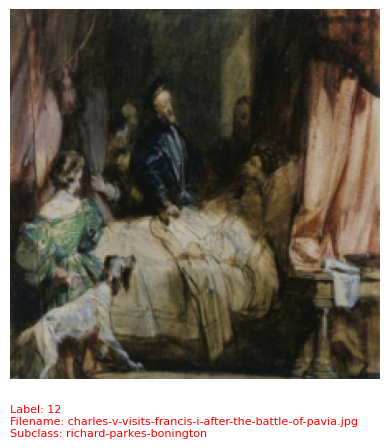

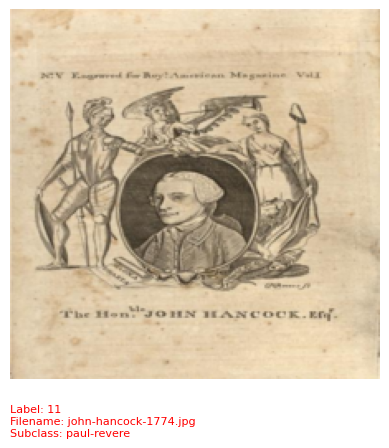

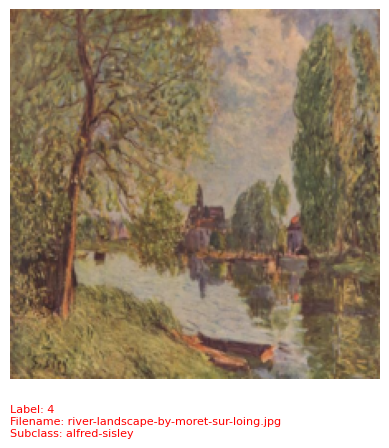

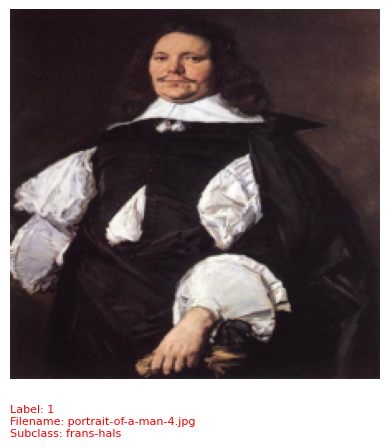

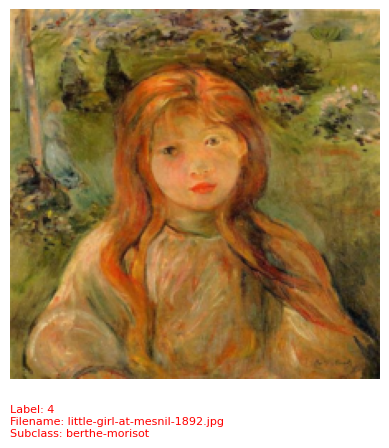

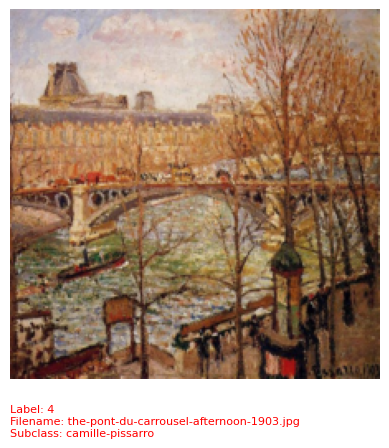

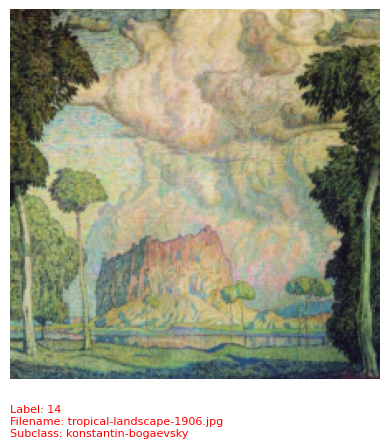

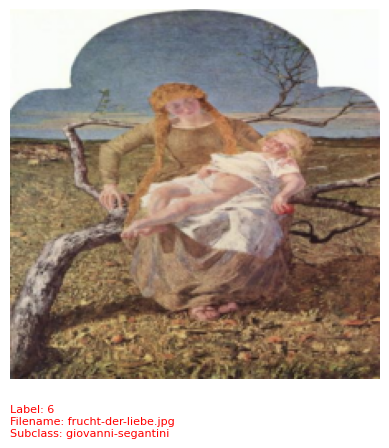

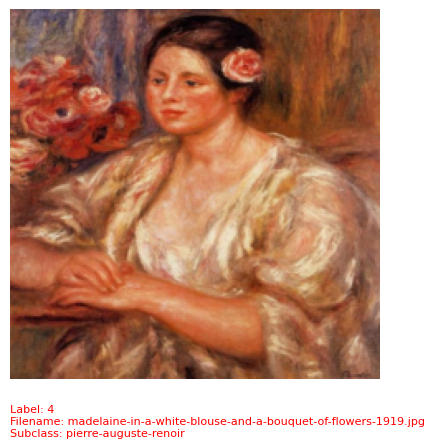

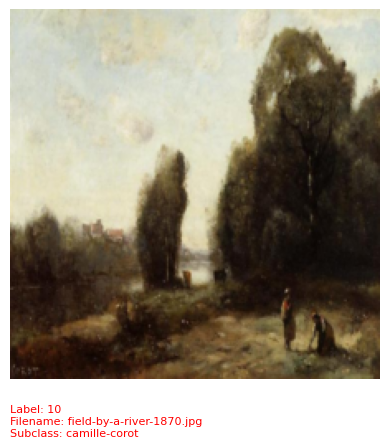

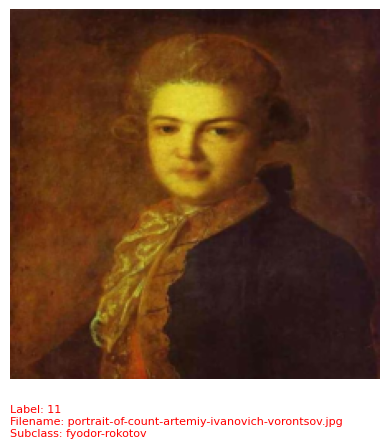

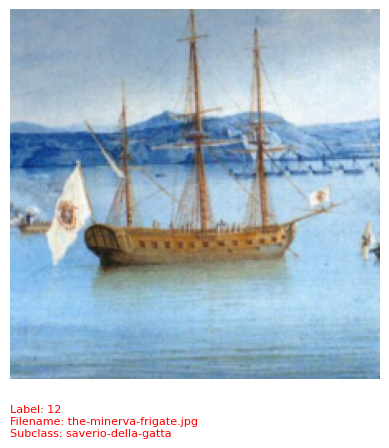

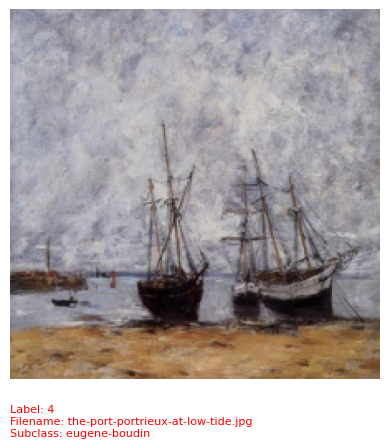

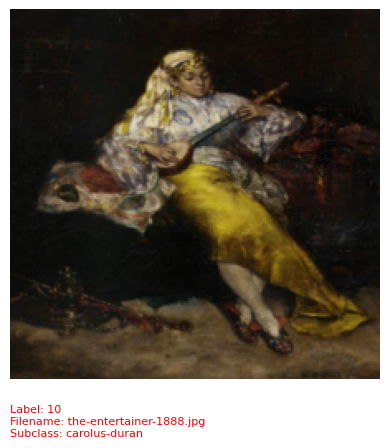

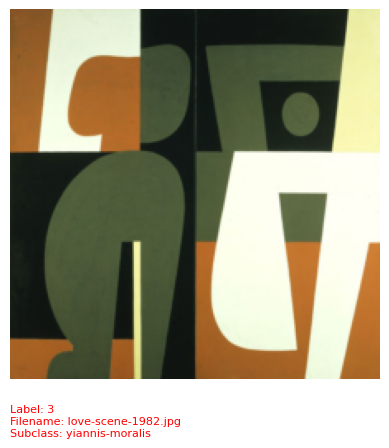

In [26]:
k = 0
# Example iteration over the DataLoader
for images, labels, filenames, sublabels in train_loader:
    # `images` contains a batch of images
    # `labels` contains the corresponding labels
    # `filenames` contains the corresponding filenames
    #
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    label = labels[0]  # Assuming labels are also in batch form
    filename = filenames[0]
    sublabel = sublabels[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.imshow(img)
    plt.axis('off')
    text = f"Label: {label}\nFilename: {filename}\nSubclass: {sublabel}"
    plt.text(0, -0.15, text, color='red', fontsize=8, transform=plt.gca().transAxes, wrap=True)  # Adjust text position and size
    plt.show()
    k += 1
    if k > 14:
        break
    pass



In [16]:
classes_list = list(classes.keys())

In [27]:
classes_list[3]

'expressionism'

## EDA

In [39]:
def count_items_in_folders(root_dir):
    """
    Count the number of items (files or subfolders) in each major class and its subclasses.

    Args:
    - root_dir (str): The root directory of the dataset.

    Returns:
    - pd.DataFrame: A DataFrame containing the counts of items in each major class and its subclasses.
    """
    data = []
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for subclass_name in os.listdir(class_path):
                subclass_path = os.path.join(class_path, subclass_name)
                if os.path.isdir(subclass_path):
                    num_items = len(os.listdir(subclass_path))
                    data.append({'Class': class_name, 'Subclass': subclass_name, 'num_items': num_items})
    df = pd.DataFrame(data)
    return df


In [40]:
# Example usage:
root_dir = './wikiart_subset'
df_wiki_subset = count_items_in_folders(root_dir)
print(df_wiki_subset)

                       Class              Subclass  num_items
0     abstract_expressionism         aaron-siskind         23
1     abstract_expressionism          ad-reinhardt         52
2     abstract_expressionism          adja-yunkers         14
3     abstract_expressionism               al-held         30
4     abstract_expressionism          albert-irvin         15
...                      ...                   ...        ...
1467               symbolism    vilhelm-hammershoi         21
1468               symbolism  vsevolod-maksymovych         16
1469               symbolism         william-blake        111
1470               symbolism   william-holman-hunt         52
1471               symbolism  zinaida-serebriakova        415

[1472 rows x 3 columns]


In [44]:
# find the number of the subclasses 
df_wiki_subset.groupby("Class")["Subclass"].count()

Class
abstract_expressionism        114
baroque                       110
ecole_de_paris                 56
expressionism                 176
impressionism                 178
naive_art_primitivism          36
neo_impressionism              11
neoclassicism                  58
post_impressionism             91
pre_raphaelite_brotherhood     19
realism                       168
rococo                         49
romanticism                   205
surrealism                    128
symbolism                      73
Name: Subclass, dtype: int64

In [57]:
total_items_per_class = df_wiki_subset.groupby("Class")["num_items"].sum()
print(total_items_per_class)

Class
abstract_expressionism         4875
baroque                        7572
ecole_de_paris                 3009
expressionism                  9187
impressionism                 16761
naive_art_primitivism          1934
neo_impressionism              1663
neoclassicism                  2264
post_impressionism             9787
pre_raphaelite_brotherhood     1239
realism                       15547
rococo                         3682
romanticism                   14829
surrealism                     6244
symbolism                      9136
Name: num_items, dtype: int64


C:\Users\Jihoon.DESKTOP-1HIBMQO\AppData\Local\Temp\ipykernel_32476\3177405647.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(total_items_per_class, shade=True)


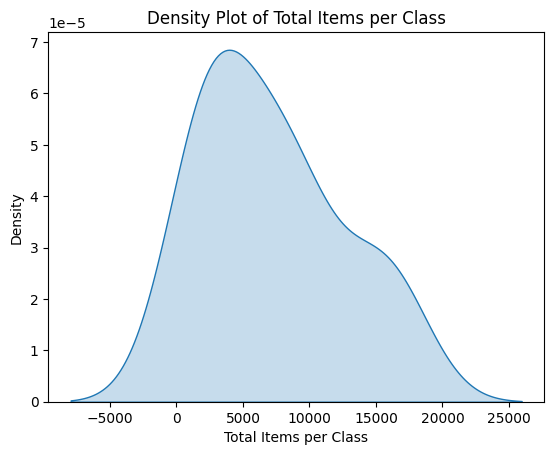

In [58]:
# Assuming total_items_per_class is your Series containing the total items 
sns.kdeplot(total_items_per_class, shade=True)
plt.xlabel('Total Items per Class')
plt.ylabel('Density')
plt.title('Density Plot of Total Items per Class')
plt.show()


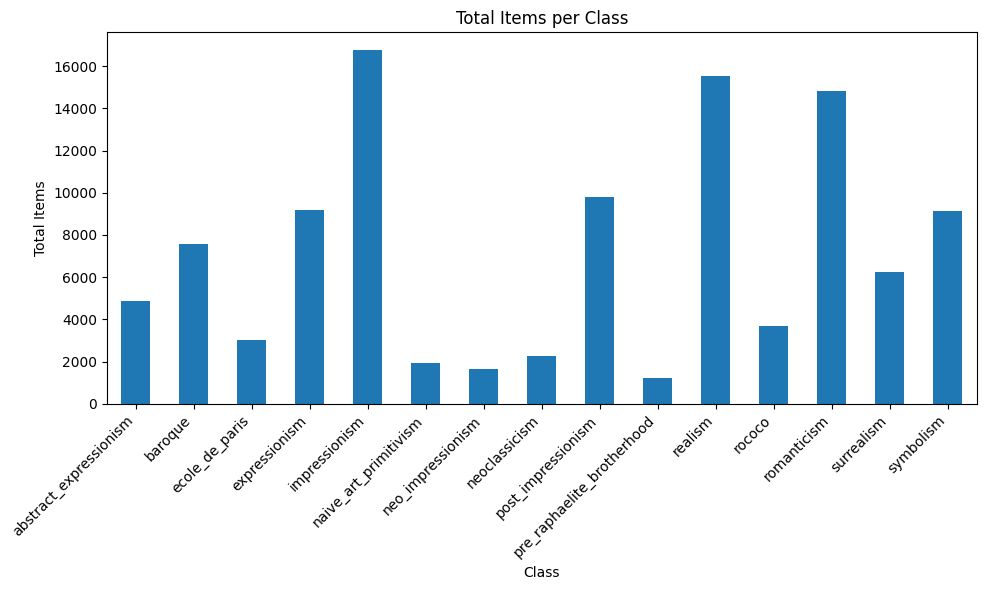

In [60]:
plt.figure(figsize=(10, 6))
total_items_per_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Total Items')
plt.title('Total Items per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### investigate subclasses which is artist

In [51]:
total_items_per_subclass = df_wiki_subset.groupby("Subclass")["num_items"].sum()
print(total_items_per_subclass)

Subclass
aaron-siskind             23
abdullah-suriosubroto     18
abidin-dino               54
abraham-storck            71
abraham-van-strij          0
                        ... 
yuriy-zlotnikov           42
yves-laloy                12
zakar-zakarian             2
zdzislaw-beksinski       707
zinaida-serebriakova     830
Name: num_items, Length: 1262, dtype: int64


In [52]:
# Identify subclasses that has a less than 5 art pieces
total_items_per_subclass[total_items_per_subclass<5]

Subclass
abraham-van-strij                 0
albert-tucker                     4
alexandre-jacovleff               0
anatoli-papian                    4
arshak-fetvadjian                 4
barbara-krafft                    0
bruno-canova                      4
carle-vernet                      0
charles-atamian                   2
charles-despiau                   0
christoffer-wilhelm-eckersberg    0
claude-joseph-vernet              0
edgar-chahine                     2
edouard-de-biefve                 3
francois-gerard                   0
fyodor-alekseyev                  0
gavin-hamilton                    0
george-dawe                       0
gheorghe-tattarescu               0
giacomo-quarenghi                 0
gohar-fermanyan                   3
guity-novin                       3
hovsep-pushman                    4
jacques-louis-david               0
jean-auguste-dominique-ingres     0
jean-jansem                       4
jean-joseph-xavier-bidauld        0
jerome-martin-langl

C:\Users\Jihoon.DESKTOP-1HIBMQO\AppData\Local\Temp\ipykernel_32476\2983880547.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(total_items_per_subclass, shade=True)


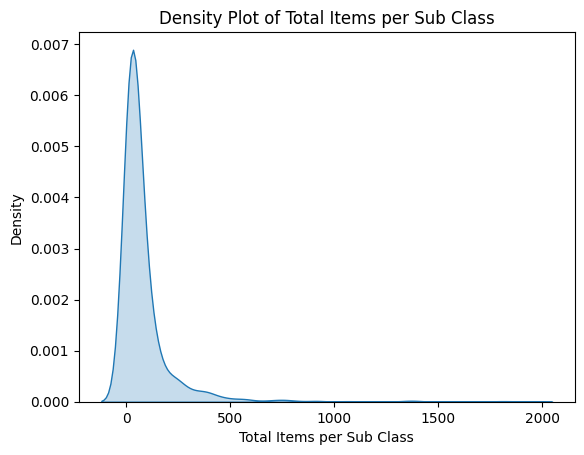

In [56]:
sns.kdeplot(total_items_per_subclass, shade=True)
plt.xlabel('Total Items per Sub Class')
plt.ylabel('Density')
plt.title('Density Plot of Total Items per Sub Class')
plt.show()

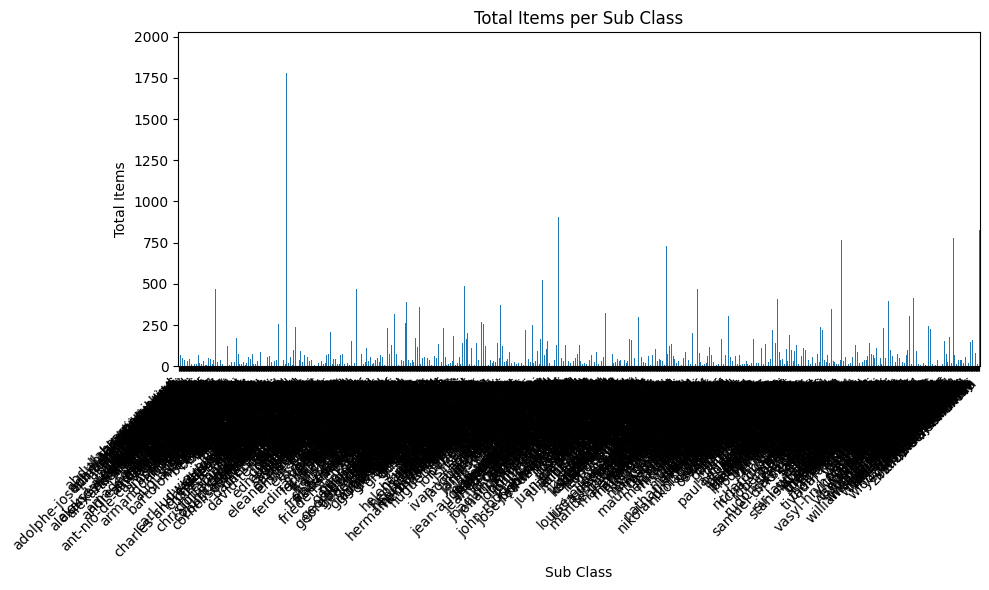

In [61]:
plt.figure(figsize=(10, 6))
total_items_per_subclass.plot(kind='bar')
plt.xlabel('Sub Class')
plt.ylabel('Total Items')
plt.title('Total Items per Sub Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Investigate correlations


In [65]:
# Assuming df is your DataFrame containing the subclass and class information
cross_tab = pd.crosstab(df_wiki_subset['Class'], df_wiki_subset['Subclass'])

# Display the cross-tabulation
print(cross_tab)

# Calculate the correlation (Pearson correlation coefficient) between subclass and class
correlation = cross_tab.corr().iloc[0, 1]
print("Correlation between subclass and class:", correlation)


Subclass                    aaron-siskind  abdullah-suriosubroto  abidin-dino  \
Class                                                                           
abstract_expressionism                  1                      0            0   
baroque                                 0                      0            0   
ecole_de_paris                          0                      0            0   
expressionism                           0                      0            0   
impressionism                           0                      0            0   
naive_art_primitivism                   0                      0            0   
neo_impressionism                       0                      0            0   
neoclassicism                           0                      0            0   
post_impressionism                      0                      0            0   
pre_raphaelite_brotherhood              0                      0            0   
realism                     

In [78]:
# Assuming df is your DataFrame containing the subclass and class information
subclass_dict = defaultdict(list)

# Iterate through the DataFrame and populate the dictionary with subclass names and corresponding classes
for _, row in df_wiki_subset.iterrows():
    subclass_dict[row['Subclass']].append(row['Class'])

# Filter the dictionary to find subclasses occurring in multiple classes
duplicate_subclasses = {subclass: classes for subclass, classes in subclass_dict.items() if len(set(classes)) > 1}

# Create a DataFrame from the duplicate_subclasses dictionary
df_duplicate_subclasses = pd.DataFrame(duplicate_subclasses.items(), columns=['Artist', 'Style'])

# Add a new column 'Num_Classes' to count the number of classes each subclass occurs in
df_duplicate_subclasses['Num_Style'] = df_duplicate_subclasses['Style'].apply(len)

# Print the DataFrame
print(df_duplicate_subclasses)

                 Artist                                    Style  Num_Style
0       alexander-bogen  [abstract_expressionism, expressionism]          2
1         bui-xuan-phai  [abstract_expressionism, expressionism]          2
2        elmer-bischoff  [abstract_expressionism, expressionism]          2
3          endre-rozsda     [abstract_expressionism, surrealism]          2
4        gunther-gerzso     [abstract_expressionism, surrealism]          2
..                  ...                                      ...        ...
192        louis-janmot                 [romanticism, symbolism]          2
193  luc-olivier-merson                 [romanticism, symbolism]          2
194    viktor-vasnetsov                 [romanticism, symbolism]          2
195       william-blake                 [romanticism, symbolism]          2
196     boleslas-biegas                  [surrealism, symbolism]          2

[197 rows x 3 columns]


In [82]:
# Sort the DataFrame by the 'Num_Classes' column in ascending order
df_duplicate_subclasses_sorted = df_duplicate_subclasses.sort_values(by='Num_Style',ascending=False)

# Print the sorted DataFrame
df_duplicate_subclasses_sorted

Artist  \
172        william-holman-hunt   
164       john-everett-millais   
179          jakub-schikaneder   
88               ivan-mrkvicka   
70                 anna-ancher   
..                         ...   
71             arkhip-kuindzhi   
72   armando-montaner-valdueza   
73                boris-schatz   
74            camille-pissarro   
196            boleslas-biegas   

                                                 Style  Num_Style  
172  [pre_raphaelite_brotherhood, romanticism, symb...          3  
164  [pre_raphaelite_brotherhood, realism, romantic...          3  
179                  [realism, romanticism, symbolism]          3  
88        [impressionism, post_impressionism, realism]          3  
70                 [impressionism, realism, symbolism]          3  
..                                                 ...        ...  
71                            [impressionism, realism]          2  
72                            [impressionism, realism]          2  
73                      [impressionism, neoclassicism]          2  
74                  [impressionism, neo_impressionism]          2  
196                            [surrealism, symbolism]          2  

[197 rows x 3 columns]

Theres no difference in the art pieces that artist have depending on the style so we may have a lot of duplicates.

In [106]:
# Concatenate the lists of styles into a single string representation
df_duplicate_subclasses_sorted['Style_Combination'] = df_duplicate_subclasses_sorted['Style'].apply(lambda x: ','.join(sorted(x)))

# Extract unique combinations of styles
unique_style_combinations = df_duplicate_subclasses_sorted['Style_Combination'].unique()

# Print the unique style combinations
print(unique_style_combinations)

# Print number of combination exist in the dataset.
print(f"\nnumber of combinations exist in {len(unique_style_combinations)}")

['pre_raphaelite_brotherhood,romanticism,symbolism'
 'pre_raphaelite_brotherhood,realism,romanticism'
 'realism,romanticism,symbolism'
 'impressionism,post_impressionism,realism'
 'impressionism,realism,symbolism'
 'ecole_de_paris,expressionism,surrealism'
 'expressionism,post_impressionism,symbolism'
 'ecole_de_paris,expressionism,post_impressionism'
 'expressionism,impressionism,post_impressionism'
 'post_impressionism,realism,symbolism'
 'ecole_de_paris,expressionism,realism' 'neoclassicism,rococo'
 'neoclassicism,romanticism' 'neoclassicism,realism'
 'abstract_expressionism,expressionism' 'naive_art_primitivism,surrealism'
 'impressionism,symbolism' 'impressionism,realism'
 'impressionism,post_impressionism' 'impressionism,neo_impressionism'
 'impressionism,romanticism' 'post_impressionism,realism'
 'realism,romanticism' 'realism,symbolism' 'rococo,romanticism'
 'romanticism,symbolism' 'pre_raphaelite_brotherhood,romanticism'
 'neo_impressionism,symbolism' 'post_impressionism,symbo

In [109]:
df_duplicate_subclasses_sorted.groupby("Style_Combination").count()

Artist  Style  Num_Style
Style_Combination                                                         
abstract_expressionism,expressionism                   5      5          5
abstract_expressionism,surrealism                      4      4          4
baroque,neoclassicism                                  1      1          1
baroque,rococo                                         4      4          4
ecole_de_paris,expressionism                          11     11         11
ecole_de_paris,expressionism,post_impressionism        1      1          1
ecole_de_paris,expressionism,realism                   1      1          1
ecole_de_paris,expressionism,surrealism                2      2          2
ecole_de_paris,impressionism                           1      1          1
ecole_de_paris,post_impressionism                      5      5          5
ecole_de_paris,surrealism                              5      5          5
expressionism,impressionism                            3      3          3
expressionism,impressionism,post_impressionism         1      1          1
expressionism,naive_art_primitivism                    2      2          2
expressionism,post_impressionism                       6      6          6
expressionism,post_impressionism,symbolism             1      1          1
expressionism,realism                                  5      5          5
expressionism,surrealism                               5      5          5
expressionism,symbolism                                6      6          6
impressionism,neo_impressionism                        2      2          2
impressionism,neoclassicism                            2      2          2
impressionism,post_impressionism                       8      8          8
impressionism,post_impressionism,realism               2      2          2
impressionism,realism                                 32     32         32
impressionism,realism,symbolism                        1      1          1
impressionism,romanticism                              2      2          2
impressionism,symbolism                                4      4          4
naive_art_primitivism,surrealism                       4      4          4
neo_impressionism,symbolism                            1      1          1
neoclassicism,realism                                  2      2          2
neoclassicism,rococo                                   8      8          8
neoclassicism,romanticism                             13     13         13
post_impressionism,realism                             1      1          1
post_impressionism,realism,symbolism                   1      1          1
post_impressionism,symbolism                           3      3          3
pre_raphaelite_brotherhood,realism,romanticism         1      1          1
pre_raphaelite_brotherhood,romanticism                15     15         15
pre_raphaelite_brotherhood,romanticism,symbolism       1      1          1
pre_raphaelite_brotherhood,symbolism                   1      1          1
realism,romanticism                                   10     10         10
realism,romanticism,symbolism                          1      1          1
realism,symbolism                                      3      3          3
rococo,romanticism                                     2      2          2
romanticism,symbolism                                  7      7          7
surrealism,symbolism                                   1      1          1